# Exergy destruction

This method for assessing stratification in a storage examines the amount of exergy destroyed in a storage due to mixing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from temperature_profile import temp_profile
from matplotlib import animation
from matplotlib.animation import FuncAnimation

Enter the simulation settings.

In [2]:
# Water proprties
density_water = 980 # in kg/m3
specific_heat_water = 4200  # in J/(kg K)

# Simulation properties
simulated_case = '' # Set the case that will be simulated, e.g. "fully_mixed", "fully_stratified". Otherwise, it simulates storage operation with mixing based on mixing_nodes.
heat_loss_coeff = 6 # in W/(m^2 K). This number gives a 90% storage efficiency for the selected settings. Set to 0 for no heat loss.

N = 60 # number of tank nodes
mix_nodes = int(N/10) # number of nodes close to the inlet that are mixed for imitating inlet jet mixing. Has to be integer!!!

T_hot = 90 # charge temperature
T_cold = 45 # discharge temperature
T_threshold = 10 # temperature threshold for considering the tank full/empty. E.g. if it is 10 degC then the tank is fully when the bottom is at 80 degC
T_amb = 10 # ambient temperature for calculatio of heat losses

th_cond_coeff = 2.5 # effective vertical thermal conductivity coefficient in W/(m K)
simulation_period = 1500 # This period is overwritten based on the maximum number of cycles set below. Has to be a large number!!
max_storage_cycles = 2 # stops the simulation after a number of charge-discharge cyles

plot = False # Plots the temperature profile in the tank

# Storage properties
storage_height = 1 # the height of storage in m
storage_volume = 1 # the volume of storage in m^3
volume_per_layer = 1/N # assuming that the storage is 1-D
mass_per_layer = density_water * volume_per_layer # mass per layer
storage_mass = density_water * storage_volume # total storage mass

Create dataframe containing the temperature profiles for each time step. Rows are the simulation time steps and columns are the layers of the storage starting from the top (0) to the bottom (N).

The "df_ancil" is a dataframe that contains the calculated heat loss entropy, storage entropy, heat loss (energy), energy rate, energy content, and charge status.

In [3]:
df, df_ancil = temp_profile(simulated_case, N, mix_nodes, T_hot, T_cold, T_threshold, th_cond_coeff, simulation_period,
                             heat_loss_coeff, plot=plot, max_storage_cycles=max_storage_cycles, T_amb=T_amb)

Plot the storage temperatrue profile over time for inspection. Instead of plotting the temperature of each node, every 5th node is plotted for better visualization.

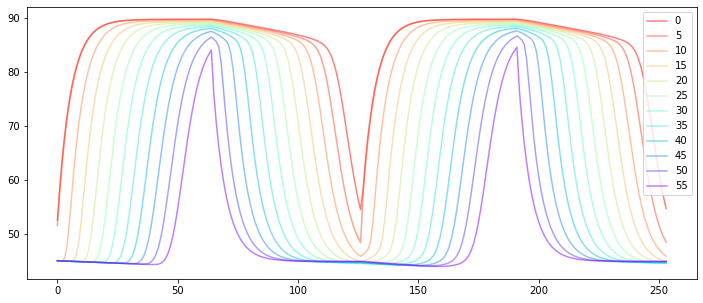

In [4]:
_ = df[np.arange(0,df.shape[1],5)].plot(cmap='rainbow_r', alpha=0.5, figsize=(12,5))

For calculating the exergy, the following general expression will be used: $$ \Delta Ex = \Delta H - T_{0} \cdot \Delta S $$

The exergy destruction is found through the following equation:
$$\Delta Ex_{destr} = \Delta Ex_{storage} - \Delta Ex_{inlet} + \Delta Ex_{outlet} + \Delta Ex_{heat loss}$$

This equation is derrived through the storage exergy balance:
$$Ex_{input} - Ex_{consumption} - Ex_{output} = Ex_{accumulation}$$

Considerations:
* Since the storage is an open system (heat and mass can flow through it) the storage exergy can be increased and decreased (but cannot be negative).
* The $Ex_{destr}$ should be negative since it is exergy destruction by mixing, heat conduction and heat diffusion.

Calculation of exergies for the experimental storage. First the inlet and outlet temperatures are defined and then exergies are calculated for the flow, storage, heat loss and internally destroyed.

In [5]:
T_0 = T_cold + 273.15 # dead state temperature

# Flows in [m3]
flow_in = volume_per_layer
flow_out = volume_per_layer

# Calculation of the temperatures in and out of the storage [°C]
T_input = []
T_output = []

for i in df.index:
    if df_ancil['charge_status'][i]==1:
        T_i = T_hot
        T_o = df.loc[i,N-1]
        T_input.append(T_i)
        T_output.append(T_o)
    else:
        T_i = T_cold
        T_o = df.loc[i,0]
        T_input.append(T_i)
        T_output.append(T_o)

T_in = pd.Series(T_input)
T_out = pd.Series(T_output)


# Enthalpy in and out of the storage [J]
H_in = flow_in * density_water * specific_heat_water * (T_in - T_cold)
H_out = flow_out * density_water * specific_heat_water * (T_out - T_cold)
H_flow = H_in - H_out

# Enthalpy (energy) of the storage, units in [J]
H_accumulated = df_ancil['energy_content']

# Enthalpy of heat loss [J]
H_heat_loss = - df_ancil['heat_loss']


# Entropy in and out of the storage [J/K]
S_in = (flow_in * density_water * specific_heat_water * (T_in - T_cold))/(T_in + 273.15)
S_out = (flow_out * density_water * specific_heat_water * (T_out - T_cold))/(T_out + 273.15)
S_flow = S_in - S_out

# Entropy content of storage in [J/K]
S_accumulated = df_ancil['storage_entropy']

# Internal entropy generation in the storage [J/K]
S_internal_generated = df_ancil['internal_entropy_generation']

# Entropy destroyed (negative sign) due to heat loss [J/K]
S_heat_loss = df_ancil['heat_loss_entropy']


# Exergy flow in the storage [J]
Ex_flow = H_flow - T_0 * S_flow

# Exergy accumulated in the storage [J]
Ex_accumulated = (H_accumulated - T_0 * S_accumulated).diff()

# Eergy destroyed due to mixing [J]
Ex_destruction = - T_0 * S_internal_generated # There is no energy creation due to mixing so DeltaH = 0

# Exergy destroyed due to heat loss [J]
Ex_heat_loss = H_heat_loss - T_0 * S_heat_loss

# Alternative calcuation of heat loss using exergy balance, for veryfying the above calculations [J]
Ex_heat_loss_calc = Ex_accumulated - Ex_flow - Ex_destruction

Plot of the calcualted exergies for the storage.

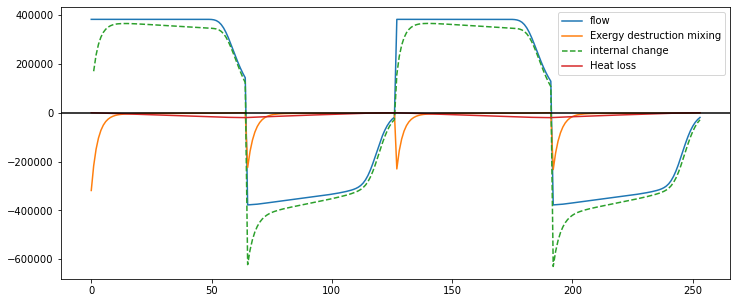

In [6]:
plt.figure(figsize=(12,5))
Ex_flow.plot(label='flow')
Ex_destruction.plot(label='Exergy destruction mixing')
Ex_accumulated.plot(label='internal change', linestyle='--')
Ex_heat_loss.plot(label='Heat loss')
plt.legend()
plt.axhline(0, c='k')

Plot of the exergy destruction due to mixing. It is initially calculated with a negative sign (which indicates destruction) but here it is plotted as positive for easier observation.

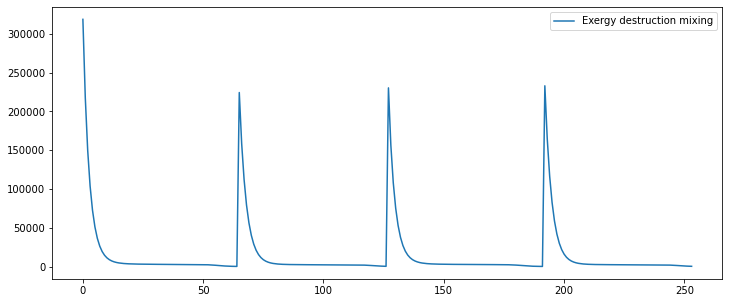

In [7]:
plt.figure(figsize=(12,5))
(-Ex_destruction).plot(label='Exergy destruction mixing')
plt.legend()